# CITS4403 Slime Mould Project
## Wenxiao Zhang 22792191

## Import code and libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from slime.dish import Dish
import pandas as pd
import networkx as nx
import math
import utils
from empiricaldist import Pmf

## Load and preprocess the dataset 

In [2]:
stations = gpd.read_file('database/nanjing_nodes.geojson')
routes = gpd.read_file('database/nanjing_edges.geojson')
# drop irrelevant columns and null value
stations = stations.drop(['name', 'marker-symbol', 'marker-size'], axis=1)
routes = routes.drop(['name', 'ref'], axis=1).reset_index()
stations = stations[~stations['marker-color'].isnull()].reset_index().drop(['index', 'marker-color'], axis=1)

### Preprocess nodes

In [3]:
stations['lon'], stations['lat'] = stations.geometry.x, stations.geometry.y
stations['value'] = 4
min_lon = min(stations['lon'])
min_lat = min(stations['lat'])
# scaling lon lat values
stations['x'] = stations.lon.apply(lambda x: int((x - min_lon) * (10**3)))
stations['y'] = stations.lat.apply(lambda y: int((y - min_lat) * (10**3)))
# subset the data
stations = stations[((stations['x']>150) & (stations['x']<500)) & ((stations['y']>530) & (stations['y']<800))]
min_x = min(stations['x'])
min_y = min(stations['y'])
stations['x'] = stations.x.apply(lambda x: int(x - min_x)+10)
stations['y'] = stations.y.apply(lambda y: int(y - min_y)+10)
stations['nodes'] = stations[['x', 'y']].apply(tuple, axis=1)
stations = stations.drop_duplicates(subset=['nodes'])
stations.head()


,geometry,lon,lat,value,x,y,nodes
0,POINT (118.86386 32.04167),118.863858,32.041670,4,201,163,"(201, 163)"
1,POINT (118.77903 32.05296),118.779027,32.052965,4,116,174,"(116, 174)"
2,POINT (118.98216 32.08657),118.982163,32.086573,4,320,208,"(320, 208)"
4,POINT (118.78943 32.04412),118.789430,32.044122,4,127,166,"(127, 166)"
5,POINT (118.71428 31.96781),118.714278,31.967809,4,52,89,"(52, 89)"


### Preprocess edges

In [4]:
routes['nodes'] = "None"
selected_stations = set()
for i, route in routes.iterrows():
    nodes = [None] * len(route['geometry'].coords)
    for k, station in stations.iterrows():
        point = station['geometry']
        if route['geometry'].distance(point) < 1e-3:
            min_dist = -1
            min_j = 0
            for j, node in enumerate(route['geometry'].coords):
                idx = (point.x, point.y)
                dist = math.dist(node, idx) 
                if dist < min_dist or min_dist == -1:
                    min_dist = dist
                    min_j = j
            if nodes[min_j] is not None:
                min_j += 1
            nodes[min_j] = station['nodes']
    nodes = [x for x in nodes if x]
    routes.at[i, 'nodes'] = nodes
routes = routes[routes['nodes'].map(lambda d: len(d)) > 0]
routes.head()

,index,stroke,geometry,nodes
4,4,#da60cd,"LINESTRING (118.50250 31.90719, 118.50285 31.9...","[(10, 77), (21, 92), (26, 99), (35, 101), (44,..."
5,5,#da60cd,"LINESTRING (118.79535 31.97445, 118.79168 31.9...","[(129, 94), (111, 86), (96, 88), (82, 86), (65..."
6,6,#009651,"LINESTRING (118.66625 32.16569, 118.66741 32.1...","[(78, 263), (102, 239), (110, 234), (118, 218)..."
7,7,#009651,"LINESTRING (118.82616 31.87100, 118.82617 31.8...","[(163, 19), (162, 32), (153, 39), (141, 51), (..."
8,8,#eac384,"LINESTRING (118.61153 32.04795, 118.61221 32.0...","[(36, 156), (48, 148), (54, 139), (50, 133), (..."


## Visualise the data in NetworkX

Saving figure to file output/original_graph.png


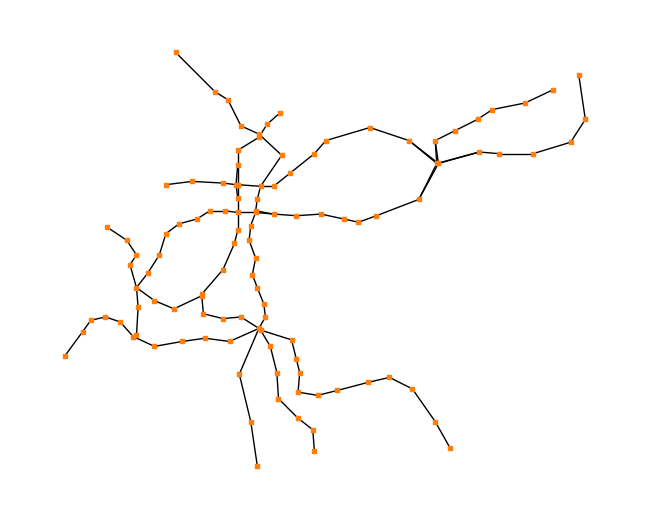

In [5]:
G = nx.Graph()
for nodes in routes['nodes']:
    for seg_start, seg_end in zip(nodes, nodes[1:]):
        G.add_edge(seg_start, seg_end)
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

fig = plt.figure(figsize=(6.3, 5))
nx.draw(G, positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
utils.savefig('output/original_graph.png')

## Slime Mould

In [6]:
start_loc = (stations.at[20,'x'], stations.at[20,'y'])

### Initialise Dish

In [7]:
dish = Dish(dish_shape=(max(stations.x) + 50, max(stations.y) + 50), foods=stations, start_loc=start_loc, mould_shape=(5, 5), init_mould_coverage=1, decay=0.17)

### Execute 50 steps

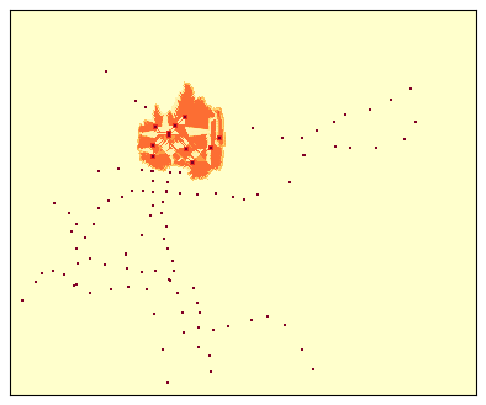

In [8]:
dish.animate(frames=50, interval=100, filename="output/50steps.gif")
plt.show()

Saving figure to file output/slime_graph_50steps.png


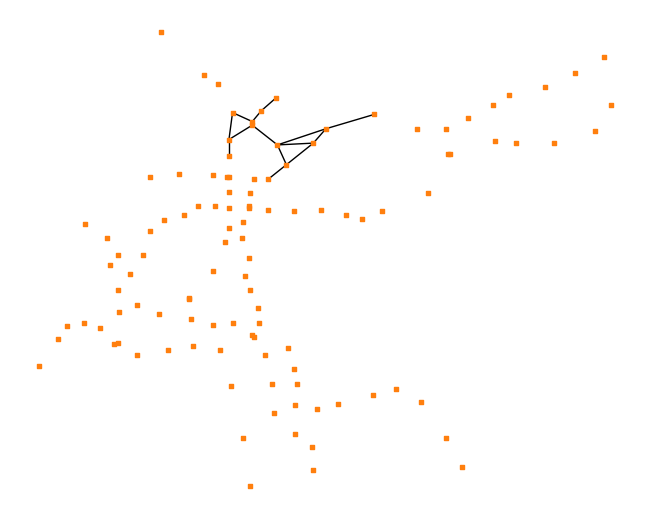

In [9]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
utils.savefig('output/slime_graph_50steps.png')

### Execute 50 + 100 steps

<Figure size 630x500 with 0 Axes>

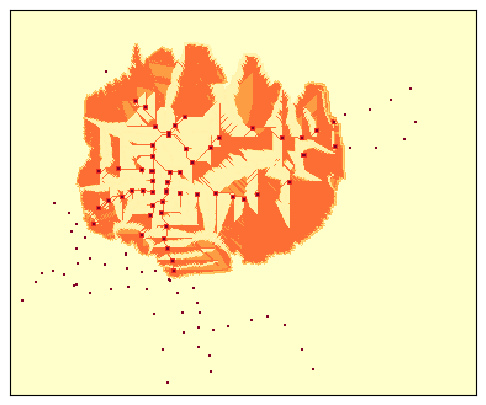

In [10]:
fig = plt.figure(figsize=(6.3, 5))
dish.animate(frames=100, interval=100, filename="output/150steps.gif")
plt.show()

Saving figure to file output/slime_graph_150steps.png


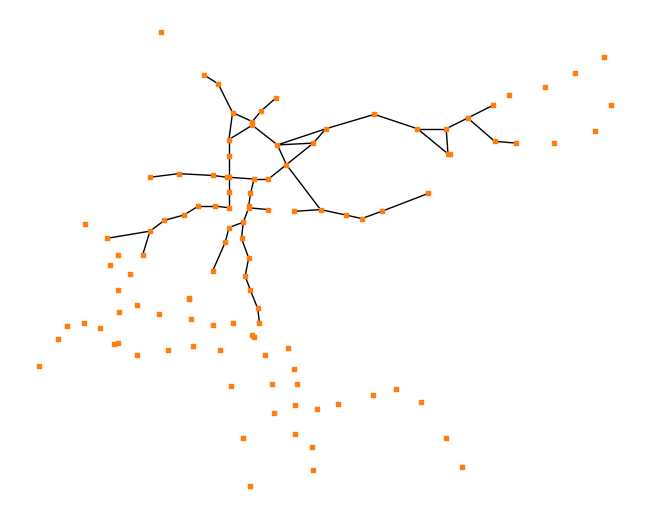

In [11]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
utils.savefig('output/slime_graph_150steps.png')

### Execute 50 + 100 + 100 steps

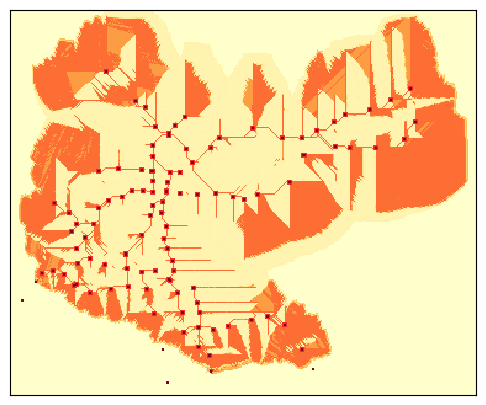

In [12]:
dish.animate(frames=100, interval=100, filename="output/250steps.gif")
plt.show()

Saving figure to file output/slime_graph_250steps.png


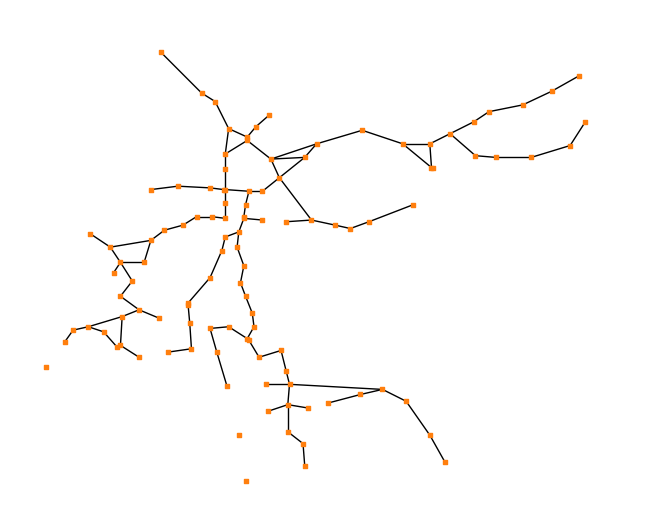

In [13]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
utils.savefig('output/slime_graph_250steps.png')

### Execute 50 + 100 + 100 + 50 steps

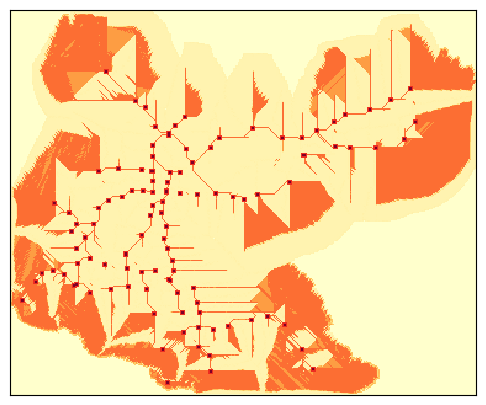

In [14]:
dish.animate(frames=50, interval=100, filename="output/300steps.gif")
plt.show()

Saving figure to file output/slime_graph_300steps.png


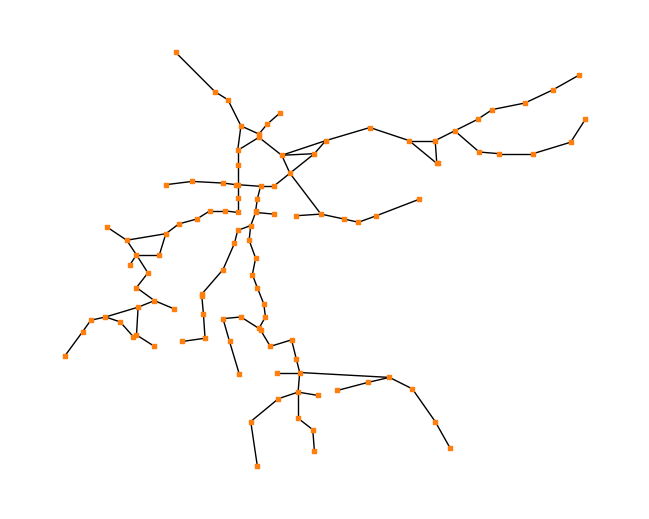

In [15]:
fig = plt.figure(figsize=(6.3, 5))
nx.draw(dish.food_graph, dish.food_positions, 
        node_color='C1', 
        node_shape='s', 
        node_size=12, 
        with_labels=False)
utils.savefig('output/slime_graph_300steps.png')

## Graph Analysis

### Clustering coefficient

In [16]:
print('Original graph: '+str(utils.clustering_coefficient(G)))
print('Graph connected by slime mould: '+str(utils.clustering_coefficient(dish.get_food_graph())))

Original graph: 0.04257425742574257
Graph connected by slime mould: 0.027777777777777773


### Path length

In [17]:
print('Original graph: '+str(utils.characteristic_path_length(G)))
print('Graph connected by slime mould: '+str(utils.characteristic_path_length(dish.get_food_graph())))

Original graph: 12.4753861003861
Graph connected by slime mould: 15.283622908622908


### Statistics

In [18]:
print('Number of Nodes: '+str(len(G.nodes)))
print('Number of edges in the orginal graph: '+str(len(G.edges)))
print('Number of edges in the graph connected by slime mould: '+str(len(dish.get_food_graph().edges)))

Number of Nodes: 112
Number of edges in the orginal graph: 122
Number of edges in the graph connected by slime mould: 118


### PMF in Linear scale

Saving figure to file output/pmf.png


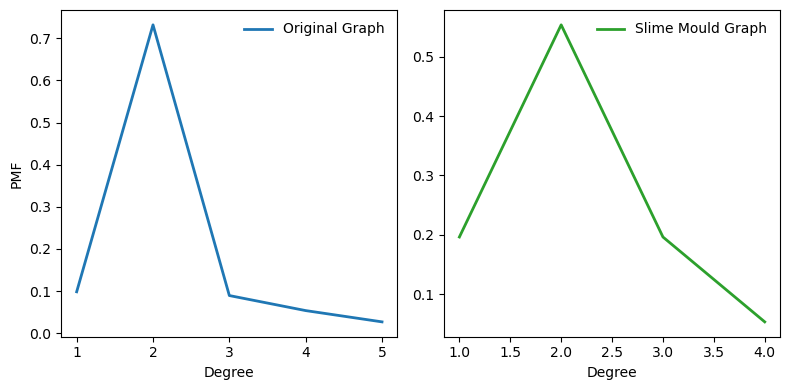

In [19]:
pmf_original = Pmf.from_seq(utils.degrees(G))
pmf_slime = Pmf.from_seq(utils.degrees(dish.get_food_graph()))
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_original.plot(label='Original Graph', color='C0')
utils.decorate(xlabel='Degree', ylabel='PMF')

plt.subplot(1,2,2)
pmf_slime.plot(label='Slime Mould Graph', color='C2')
utils.decorate(xlabel='Degree')
utils.savefig('output/pmf.png')

## Agent Analysis

### Average pheromone of active Agents

Saving figure to file output/avg_ph.png


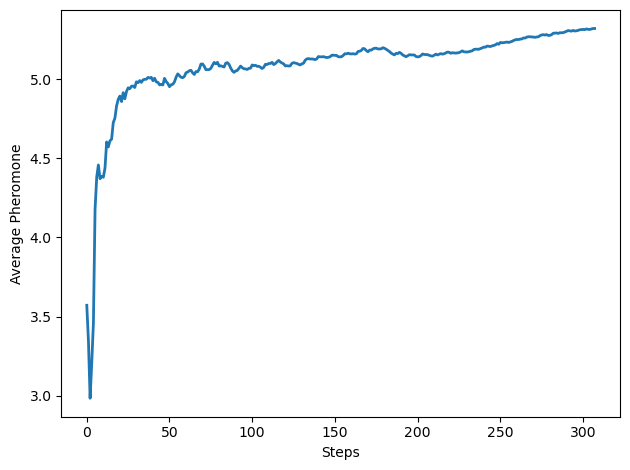

In [20]:
plt.plot(dish.mould.get_avg_ph())
utils.decorate(xlabel='Steps', ylabel='Average Pheromone', loc='upper left')
utils.savefig('output/avg_ph.png')

### Number of Agents

Saving figure to file output/agent_num.png


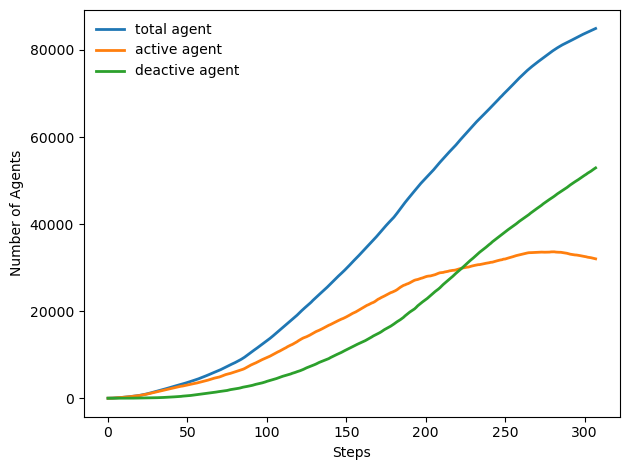

In [21]:
plt.plot(dish.mould.get_total_num(), label='total agent')
plt.plot(dish.mould.get_total_active_num(), label='active agent')
plt.plot(dish.mould.get_total_deactive_num(), label='deactive agent')
utils.decorate(xlabel='Steps', ylabel='Number of Agents', loc='upper left')
utils.savefig('output/agent_num.png')

### Slime mould coverage ratio

Saving figure to file output/cover_ratio.png


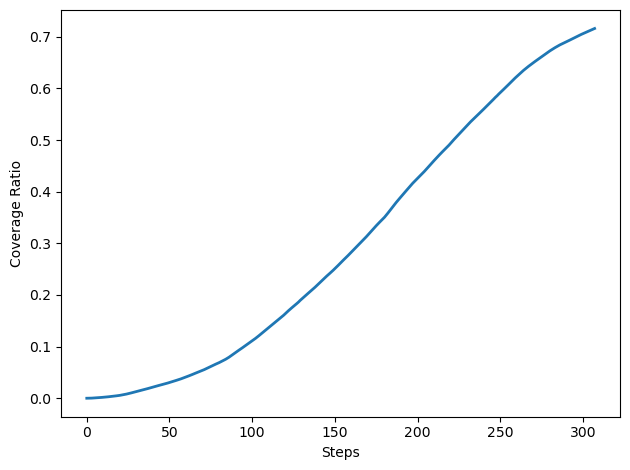

In [22]:
plt.plot(dish.mould.get_coverage_ratio())
utils.decorate(xlabel='Steps', ylabel='Coverage Ratio', loc='upper left')
utils.savefig('output/cover_ratio.png')

### Total number of connected food

Saving figure to file output/connected_food.png


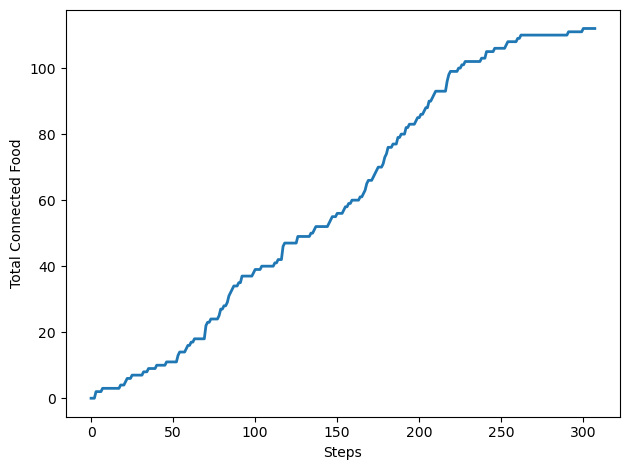

In [23]:
plt.plot(dish.mould.get_total_reached_foods())
utils.decorate(xlabel='Steps', ylabel='Total Connected Food', loc='upper left')
utils.savefig('output/connected_food.png')